# Train the model with a set of images

In [156]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
# from sklearn import tree
import os
import random
import tensorflow as tf

from IPython.display import Image, SVG

mpl.rc('image', cmap='gray_r')
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from keras.datasets import mnist
from keras.preprocessing import image

## Useful methods

In [210]:
def rot90ccw(mat):
    """ Rotate an n by n matrix 90 deg counter clock wise"""
    
    # rotation matrix
    rot = np.array([[0, 1],
               [-1,0]])
    # matrix coordinates
    coord = [i for i in np.ndindex(mat.shape)]
    nbp = mat.shape[0]    
    # initialisations
    coord_rot = []
    mat_rot = np.zeros((mat.shape))    
    # Apply the transformation on each pixel's coordinates
    for ii in range(0,len(coord)):
        # apply the rotation to the coordinate vector
        coord_rot.append(coord[ii]@rot)
        # reverse the row axis
        coord_rot[ii][0] += nbp-1
        # transform back into a tuple
        coord_rot[ii] = tuple(coord_rot[ii])   
        # fill up the rotated matrix
        mat_rot[coord_rot[ii]] = mat[coord[ii]]        
    
    return mat_rot

def rot90cw(mat):
    """ Rotate an n by n matrix 90 deg clock wise"""
    
    # rotation matrix
    rot = np.array([[0, -1],
               [1,0]])    
    # matrix coordinates
    coord = [i for i in np.ndindex(mat.shape)]
    nbp = mat.shape[0]    
    # initialisations
    coord_rot = []
    mat_rot = np.zeros((mat.shape))    
    # Apply the transformation on each pixel's coordinates
    for ii in range(0,len(coord)):
        # apply the rotation to the coordinate vector
        coord_rot.append(coord[ii]@rot)
        # reverse the row axis
        coord_rot[ii][1] += nbp-1
        # transform back into a tuple
        coord_rot[ii] = tuple(coord_rot[ii])   
        # fill up the rotated matrix
        mat_rot[coord_rot[ii]] = mat[coord[ii]]        
    
    return mat_rot

In [211]:
# Transformation matrices
def create_PPstar_translation(nbpix):
    # nb of pixels translated
    nbt = int(np.round(0.25*nbpix))

    # bottom left square block
    bl = np.eye(nbpix-nbt,nbpix-nbt)
    # upper right square block
    ur = np.eye(nbt,nbt)
    # upper left rect block
    ul = np.zeros((nbt,nbpix-nbt))
    # bottom right rect block
    br = np.zeros((nbpix-nbt,nbt))

    # concatenate the blocks to build the transformation matrix
    P = np.concatenate((np.concatenate((ul,ur), axis=1), np.concatenate((bl,br), axis=1)), axis=0)
    Pstar = np.linalg.inv(P)        
    return (P,Pstar)

def translate2left(mat):
    P,Pstar = create_PPstar_translation(mat.shape[0])
    return mat@P
def translate2right(mat):
    P,Pstar = create_PPstar_translation(mat.shape[0])
    return mat@Pstar


In [212]:
# plt.figure(1)
def remove_ticks():
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off    
    return

def vis_matrices(Mr, Mm, Mst, MstM):
#     print(Mr.shape[0])
    if Mr.shape[0]==1:
        Mr = Mr.reshape(int(np.sqrt(Mr.shape[1])), int(np.sqrt(Mr.shape[1])))
        Mm = Mm.reshape(int(np.sqrt(Mm.shape[1])), int(np.sqrt(Mm.shape[1])))
        Mst = Mst.reshape(int(np.sqrt(Mst.shape[1])), int(np.sqrt(Mst.shape[1])))
        MstM = MstM.reshape(int(np.sqrt(Mst.shape[1])), int(np.sqrt(Mst.shape[1])))

    
    fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=2) #, squeeze=True, sharey=True)
    fig.set_size_inches(8,8)

    plt.sca(ax1[0])
    plt.imshow(Mr)
    plt.title("Real image")
    remove_ticks()

    plt.sca(ax2[0])
    plt.imshow(Mm)
    plt.title("Distorted image")
    remove_ticks()

    plt.sca(ax1[1])
    plt.imshow(Mst)
    plt.title("Corrected input")
    remove_ticks()

    plt.sca(ax2[1])
    plt.imshow(MstM)
    plt.title("Corrected visualization")
    remove_ticks()

In [240]:
def create_door_img(nbpix):
    """ Create an nbpix by nbpix image of a door"""
    nbborder = int(np.round(nbpix*0.3))
    u = np.ones((nbborder,nbpix))
    l = np.ones((nbpix-nbborder,nbborder))
    r = l
    door = np.zeros((nbpix-nbborder, nbpix-2*nbborder))

    return np.concatenate((u,np.concatenate((l,door,r), axis=1)), axis=0)

 ## MAIN

In [217]:
# Parameters
nbpix = 8 # nb of pixel to consider (nbpix x nbpix)
transform_type = "translation" # type of transformation : "translation" or "rotation"
training_type = "full" # type of training: "partial" of "full"

In [233]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Scaling the data from 0 to 1 and selecting only the 1000 first images
X_train = X_train[0:50,:]/255
# X_train = X_train/255

print("Training Data Info")
print("Training Data Shape:", X_train.shape)
type(X_train)
# X_train[7,:, :]

Training Data Info
Training Data Shape: (50, 28, 28)


numpy.ndarray

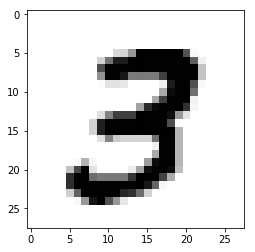

In [234]:
plt.imshow(X_train[7,:, :]) #, cmap=plt.cm.Greys)

In [235]:
import cv2
# resize the dataset into nbpix+1 x nbpix+1 arrays
X_train2 = np.zeros((X_train.shape[0], nbpix**2))
for ii in range(0,X_train.shape[0]):
    # resize the image 
    img_resize = cv2.resize(X_train[ii,:,:], dsize=(nbpix+2,nbpix+2), interpolation=cv2.INTER_CUBIC)
    # remove the frame
    img_resize = np.delete(img_resize, 0,0)
    img_resize = np.delete(img_resize,0,1)
    img_resize = np.delete(img_resize,-1,0)
    img_resize = np.delete(img_resize,-1,1)
    # flatten the table
    img_flat = img_resize.reshape(1,nbpix**2)
    # transform into black and white
    img_bw = (img_flat > 0.05).astype(int)
    # save into the table
    X_train2[ii,:] = img_bw
    

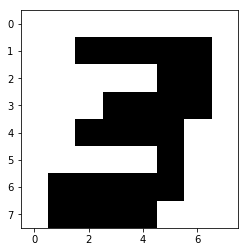

In [236]:
plt.imshow(X_train2[7,:].reshape(nbpix,nbpix))

In [237]:
# Now we need to replace the training results by the mangled and corrected matrices
transform_type = "rotation"
Mmang_tab = np.zeros(X_train2.shape)
Mcor_tab = np.zeros(X_train2.shape)

for ii in range(0, X_train2.shape[0]):
    if transform_type == "translation":
        Mmang_tab[ii,:] = translate2left(X_train2[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)
        Mcor_tab[ii,:] = translate2right(X_train2[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)
    elif transform_type == "rotation":
        Mmang_tab[ii,:] = rot90ccw(X_train2[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)
        Mcor_tab[ii,:] = rot90cw(X_train2[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)


In [239]:
node_nb = min(max(100, 5*nbpix**2), 300)
epoch_nb = min(max(100, 5*nbpix**2), 300)

# creating the models
model_mangler = Sequential()
model_mangler.add(Dense(node_nb, activation='relu', input_dim=nbpix**2))
model_mangler.add(Dense(node_nb, activation='relu'))
model_mangler.add(Dense(nbpix**2, activation='softmax'))
# Inversion strategy doesnt work very well...
# we are going to try using another model, trained on the corrected input.
model_corrector = Sequential()
model_corrector.add(Dense(node_nb, activation='relu', input_dim=nbpix**2))
model_corrector.add(Dense(node_nb, activation='relu'))
model_corrector.add(Dense(nbpix**2, activation='softmax'))

# Compile the models
model_mangler.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])
model_corrector.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])

# train the model "mangler"
model_mangler.fit( X_train2,
    Mmang_tab,
    epochs=epoch_nb,
    shuffle=True,
    verbose=1
)

# train the corrected input model
model_corrector.fit( X_train2,
    Mcor_tab,
    epochs=epoch_nb,
    shuffle=True,
    verbose=1
)    

Epoch 1/300
50/50 [==============================] - 1s 10ms/step - loss: 80.2289 - acc: 0.0200
Epoch 2/300
50/50 [==============================] - 0s 420us/step - loss: 77.9174 - acc: 0.0200
Epoch 3/300
50/50 [==============================] - 0s 360us/step - loss: 75.5594 - acc: 0.0000e+00
Epoch 4/300
50/50 [==============================] - 0s 320us/step - loss: 73.9051 - acc: 0.0000e+00
Epoch 5/300
50/50 [==============================] - 0s 420us/step - loss: 72.8128 - acc: 0.0000e+00
Epoch 6/300
50/50 [==============================] - 0s 320us/step - loss: 71.6947 - acc: 0.0600
Epoch 7/300
50/50 [==============================] - 0s 460us/step - loss: 70.9302 - acc: 0.0200
Epoch 8/300
50/50 [==============================] - 0s 360us/step - loss: 70.1200 - acc: 0.0000e+00
Epoch 9/300
50/50 [==============================] - 0s 460us/step - loss: 69.2348 - acc: 0.0000e+00
Epoch 10/300
50/50 [==============================] - 0s 460us/step - loss: 68.5031 - acc: 0.0000e+00
Epoch 

50/50 [==============================] - 0s 300us/step - loss: 58.4776 - acc: 0.0800
Epoch 84/300
50/50 [==============================] - 0s 340us/step - loss: 58.4412 - acc: 0.0000e+00
Epoch 85/300
50/50 [==============================] - 0s 280us/step - loss: 58.3614 - acc: 0.0800
Epoch 86/300
50/50 [==============================] - 0s 340us/step - loss: 58.3585 - acc: 0.0000e+00
Epoch 87/300
50/50 [==============================] - 0s 340us/step - loss: 58.3685 - acc: 0.0400
Epoch 88/300
50/50 [==============================] - 0s 300us/step - loss: 58.3568 - acc: 0.0400
Epoch 89/300
50/50 [==============================] - 0s 300us/step - loss: 58.3219 - acc: 0.0800
Epoch 90/300
50/50 [==============================] - 0s 280us/step - loss: 58.3106 - acc: 0.0600
Epoch 91/300
50/50 [==============================] - 0s 300us/step - loss: 58.2658 - acc: 0.0400
Epoch 92/300
50/50 [==============================] - 0s 440us/step - loss: 58.2877 - acc: 0.0200
Epoch 93/300
50/50 [=====

50/50 [==============================] - 0s 280us/step - loss: 58.1196 - acc: 0.0600
Epoch 166/300
50/50 [==============================] - 0s 280us/step - loss: 58.1216 - acc: 0.0200
Epoch 167/300
50/50 [==============================] - 0s 420us/step - loss: 58.1190 - acc: 0.0200
Epoch 168/300
50/50 [==============================] - 0s 380us/step - loss: 58.1281 - acc: 0.0200
Epoch 169/300
50/50 [==============================] - 0s 320us/step - loss: 58.1334 - acc: 0.1200
Epoch 170/300
50/50 [==============================] - 0s 500us/step - loss: 58.1219 - acc: 0.0600
Epoch 171/300
50/50 [==============================] - 0s 400us/step - loss: 58.1157 - acc: 0.0200
Epoch 172/300
50/50 [==============================] - 0s 460us/step - loss: 58.1043 - acc: 0.0400
Epoch 173/300
50/50 [==============================] - 0s 480us/step - loss: 58.1165 - acc: 0.1800
Epoch 174/300
50/50 [==============================] - 0s 500us/step - loss: 58.1055 - acc: 0.0400
Epoch 175/300
50/50 [===

50/50 [==============================] - 0s 300us/step - loss: 58.1514 - acc: 0.0200
Epoch 248/300
50/50 [==============================] - 0s 260us/step - loss: 58.1115 - acc: 0.0600
Epoch 249/300
50/50 [==============================] - 0s 260us/step - loss: 58.0954 - acc: 0.0600
Epoch 250/300
50/50 [==============================] - 0s 460us/step - loss: 58.0990 - acc: 0.0600
Epoch 251/300
50/50 [==============================] - 0s 300us/step - loss: 58.1046 - acc: 0.0200
Epoch 252/300
50/50 [==============================] - 0s 300us/step - loss: 58.0956 - acc: 0.0000e+00
Epoch 253/300
50/50 [==============================] - 0s 320us/step - loss: 58.0895 - acc: 0.0600
Epoch 254/300
50/50 [==============================] - 0s 420us/step - loss: 58.0858 - acc: 0.0400
Epoch 255/300
50/50 [==============================] - 0s 360us/step - loss: 58.0779 - acc: 0.0200
Epoch 256/300
50/50 [==============================] - 0s 300us/step - loss: 58.0779 - acc: 0.0400
Epoch 257/300
50/50 

50/50 [==============================] - 0s 200us/step - loss: 60.8618 - acc: 0.0600
Epoch 30/300
50/50 [==============================] - 0s 200us/step - loss: 60.6637 - acc: 0.0600
Epoch 31/300
50/50 [==============================] - 0s 240us/step - loss: 60.4659 - acc: 0.0600
Epoch 32/300
50/50 [==============================] - 0s 180us/step - loss: 60.3048 - acc: 0.0800
Epoch 33/300
50/50 [==============================] - 0s 240us/step - loss: 60.1409 - acc: 0.0600
Epoch 34/300
50/50 [==============================] - 0s 200us/step - loss: 60.0045 - acc: 0.0600
Epoch 35/300
50/50 [==============================] - 0s 180us/step - loss: 59.8755 - acc: 0.0600
Epoch 36/300
50/50 [==============================] - 0s 280us/step - loss: 59.7573 - acc: 0.0200
Epoch 37/300
50/50 [==============================] - 0s 260us/step - loss: 59.6585 - acc: 0.1000
Epoch 38/300
50/50 [==============================] - 0s 240us/step - loss: 59.5410 - acc: 0.1000
Epoch 39/300
50/50 [=============

50/50 [==============================] - 0s 220us/step - loss: 58.1763 - acc: 0.0200
Epoch 111/300
50/50 [==============================] - 0s 200us/step - loss: 58.1688 - acc: 0.0000e+00
Epoch 112/300
50/50 [==============================] - 0s 240us/step - loss: 58.1825 - acc: 0.0600
Epoch 113/300
50/50 [==============================] - 0s 240us/step - loss: 58.1793 - acc: 0.0000e+00
Epoch 114/300
50/50 [==============================] - 0s 200us/step - loss: 58.1664 - acc: 0.0400
Epoch 115/300
50/50 [==============================] - 0s 280us/step - loss: 58.1532 - acc: 0.0000e+00
Epoch 116/300
50/50 [==============================] - 0s 220us/step - loss: 58.1502 - acc: 0.0200
Epoch 117/300
50/50 [==============================] - 0s 260us/step - loss: 58.1505 - acc: 0.0200
Epoch 118/300
50/50 [==============================] - 0s 320us/step - loss: 58.1510 - acc: 0.1000
Epoch 119/300
50/50 [==============================] - 0s 340us/step - loss: 58.1435 - acc: 0.0600
Epoch 120/30

50/50 [==============================] - 0s 260us/step - loss: 58.1101 - acc: 0.0000e+00
Epoch 193/300
50/50 [==============================] - 0s 320us/step - loss: 58.0952 - acc: 0.0800
Epoch 194/300
50/50 [==============================] - 0s 260us/step - loss: 58.1024 - acc: 0.0400
Epoch 195/300
50/50 [==============================] - 0s 180us/step - loss: 58.1068 - acc: 0.1000
Epoch 196/300
50/50 [==============================] - 0s 180us/step - loss: 58.1013 - acc: 0.0600
Epoch 197/300
50/50 [==============================] - 0s 200us/step - loss: 58.1022 - acc: 0.0600
Epoch 198/300
50/50 [==============================] - 0s 340us/step - loss: 58.0865 - acc: 0.1400
Epoch 199/300
50/50 [==============================] - 0s 280us/step - loss: 58.0872 - acc: 0.0600
Epoch 200/300
50/50 [==============================] - 0s 300us/step - loss: 58.0901 - acc: 0.0600
Epoch 201/300
50/50 [==============================] - 0s 340us/step - loss: 58.0949 - acc: 0.1000
Epoch 202/300
50/50 

50/50 [==============================] - 0s 200us/step - loss: 58.1594 - acc: 0.0000e+00
Epoch 275/300
50/50 [==============================] - 0s 240us/step - loss: 58.1212 - acc: 0.0000e+00
Epoch 276/300
50/50 [==============================] - 0s 180us/step - loss: 58.0917 - acc: 0.0000e+00
Epoch 277/300
50/50 [==============================] - 0s 280us/step - loss: 58.1137 - acc: 0.0000e+00
Epoch 278/300
50/50 [==============================] - 0s 200us/step - loss: 58.1248 - acc: 0.0000e+00
Epoch 279/300
50/50 [==============================] - 0s 220us/step - loss: 58.1101 - acc: 0.0200
Epoch 280/300
50/50 [==============================] - 0s 220us/step - loss: 58.1047 - acc: 0.0200
Epoch 281/300
50/50 [==============================] - 0s 300us/step - loss: 58.0963 - acc: 0.0000e+00
Epoch 282/300
50/50 [==============================] - 0s 280us/step - loss: 58.1096 - acc: 0.1000
Epoch 283/300
50/50 [==============================] - 0s 260us/step - loss: 58.0859 - acc: 0.0200
